In [1]:
# Importação de bibliotecas essenciais para análise de dados, visualização e machine learning
import numpy as np  # Para operações numéricas e manipulação de arrays
import pandas as pd  # Para manipulação de dados em formato de tabela (DataFrames)
import matplotlib.pyplot as plt  # Para criação de gráficos e visualizações
import seaborn as sns  # Para visualizações estatísticas mais avançadas e atraentes

# Ferramentas de machine learning e avaliação de modelos
from sklearn.model_selection import train_test_split, StratifiedKFold  # Para divisão dos dados e validação cruzada
from sklearn.metrics import (  # Métricas de avaliação de modelos
    precision_score, recall_score, balanced_accuracy_score, matthews_corrcoef,
    f1_score, accuracy_score, roc_curve, auc,
)
from sklearn.preprocessing import StandardScaler  # Para normalização dos dados
from datetime import datetime, timedelta  # Para manipulação de datas e horários
import logging  # Para registro de logs durante a execução
import warnings  # Para suprimir avisos durante a execução
from tqdm import tqdm  # Para barras de progresso em loops

# Modelos de machine learning
from sklearn.ensemble import RandomForestClassifier  # Random Forest para seleção de features
from sklearn.neural_network import MLPClassifier  # Rede Neural Multicamadas (MLP) para classificação


# Configurações iniciais
warnings.filterwarnings("ignore")  # Ignora avisos durante a execução
logging.getLogger("optuna").setLevel(logging.CRITICAL)  # Configura o nível de logs para "CRITICAL" (suprime logs desnecessários)

# Dicinário de Dados


| **Variável**         | **Tipo**   | **Descrição**                                                                                                                                     |
|-----------------------|------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| RowNumber            | int64      | Número do registro (linhas), sem efeito na construção de modelos.                                                                                |
| CustomerId           | int64      | ID do cliente, sem efeito sobre o estudo.                                                                                                       |
| Surname              | object     | Sobrenome do cliente, sem impacto na análise.                                                                                                   |
| CreditScore          | int64      | Pontuação de crédito, pode indicar tendência de permanência de clientes com pontuação alta.                                                     |
| Geography            | object     | Localização do cliente, pode influenciar a decisão de evasão.                                                                                   |
| Gender               | object     | Gênero do cliente, possível influência na evasão.                                                                                               |
| Age                  | int64      | Idade do cliente, clientes mais velhos tendem a permanecer.                                                                                     |
| Tenure               | int64      | Anos que o cliente está no banco, clientes novos têm maior chance de evasão.                                                                    |
| Balance              | float64    | Saldo na conta, pessoas com saldos altos são menos propensas a sair.                                                                            |
| NumOfProducts        | int64      | Número de produtos adquiridos pelo cliente.                                                                                                    |
| HasCrCard            | int64      | Indica se o cliente tem cartão de crédito, clientes com cartão são menos propensos à evasão.                                                    |
| IsActiveMember       | int64      | Clientes ativos têm menor chance de evasão.                                                                                                    |
| EstimatedSalary      | float64    | Salário estimado, clientes com salários mais altos tendem a permanecer.                                                                         |
| Exited               | int64      | Indica se o cliente saiu ou não do banco, variável de predição (“churn”).                                                                       |
| Complain             | int64      | Indica se o cliente fez reclamação.                                                                                                             |
| Satisfaction Score   | int64      | Pontuação de satisfação com a resolução de reclamação.                                                                                          |
| Card Type            | object     | Tipo de cartão que o cliente possui.                                                                                                            |
| Points Earned        | int64      | Pontos ganhos pelo cliente.                                                                                                                     |


In [5]:
# Carregando o dataset de Churn de Clientes
try:
    dados_clientes = pd.read_csv('Customer-Churn-Records.csv', sep=',')  # Caminho para o arquivo local
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado. Verifique o caminho do arquivo.")

# Configurações para exibição do DataFrame no notebook
pd.set_option('display.expand_frame_repr', False)  # Impede que o DataFrame seja quebrado em várias linhas
pd.set_option('display.max_columns', None)  # Exibe todas as colunas do DataFrame, sem truncamento

# Exibindo as primeiras linhas do DataFrame para inspeção inicial
print("\nPrimeiras linhas do dataset:")
print(dados_clientes.head())

Dataset carregado com sucesso!

Primeiras linhas do dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  Point Earned
0          1    15634602  Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1         1                   2   DIAMOND           464
1          2    15647311      Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0         1                   3   DIAMOND           456
2          3    15619304      Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1         1                   3   DIAMOND           377
3          4    15701354      Boni          699    France  Female   39       1       0.00      

In [7]:
# Verificando as dimensões do dataset
print("Número de linhas:", dados_clientes.shape[0])  # Retorna o número de linhas (registros) no DataFrame
print("Número de colunas:", dados_clientes.shape[1])  # Retorna o número de colunas (variáveis) no DataFrame

Número de linhas: 10000
Número de colunas: 18


In [8]:
# Verificando os tipos de dados das colunas do dataset
print("Tipos de dados das colunas:")
print(dados_clientes.dtypes)

Tipos de dados das colunas:
RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object


In [9]:
# Verificando a presença de valores nulos no dataset
print("Contagem de valores nulos por coluna:")
print(dados_clientes.isnull().sum())

Contagem de valores nulos por coluna:
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64


In [18]:
# Removendo colunas meramente identificadoras (RowNumber, CustomerId, Surname)
df = dados_clientes[['CreditScore',
                              'Gender',
                              'Geography',
                              'Age',
                              'Tenure',
                              'Balance',
                              'NumOfProducts',
                              'HasCrCard',
                              'IsActiveMember',
                              'EstimatedSalary',
                              'Complain',
                              'Satisfaction Score',
                              'Card Type',
                              'Point Earned',
                              'Exited'
                             ]]

# Selecionando colunas quantitativas para análise estatística
variaveis_quantitativas = df[['EstimatedSalary', 'Balance', 'CreditScore', 'Age', 'Tenure', 'Point Earned']]

# Gerando resumo estatístico com formatação personalizada
resumo_estatistico = variaveis_quantitativas.describe().style.format("{:.1f}")  # Formatação com 1 casa decimal

# Exibindo o resumo estatístico
print("Resumo estatístico das variáveis quantitativas:")
resumo_estatistico

Resumo estatístico das variáveis quantitativas:


,EstimatedSalary,Balance,CreditScore,Age,Tenure,Point Earned
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,100090.2,76485.9,650.5,38.9,5.0,606.5
std,57510.5,62397.4,96.7,10.5,2.9,225.9
min,11.6,0.0,350.0,18.0,0.0,119.0
25%,51002.1,0.0,584.0,32.0,3.0,410.0
50%,100193.9,97198.5,652.0,37.0,5.0,605.0
75%,149388.2,127644.2,718.0,44.0,7.0,801.0
max,199992.5,250898.1,850.0,92.0,10.0,1000.0


### Análise Inicial do Dataset Distribuições e Desbalanceamento:

As distribuições das variáveis quantitativas estão dentro de faixas razoáveis, sem valores absurdos ou outliers extremos.

As variáveis Complain e Exited (Churn) estão desbalanceadas, com a maioria dos clientes não tendo registrado reclamações ou deixado o banco. Isso exigirá técnicas de balanceamento, como oversampling ou pesos de classe, para garantir que o modelo consiga prever corretamente a classe minoritária.

Distribuição Geográfica:

A França é o país com mais clientes no dataset, enquanto Alemanha e Espanha têm menos representação. Essa distribuição desproporcional pode introduzir viés geográfico no modelo, e deve ser considerada durante a análise.

Cartão de Crédito e Produtos:

A maioria dos clientes possui cartão de crédito, indicando que esse é um produto popular. No entanto, é importante verificar se a posse de cartão de crédito está correlacionada com o Churn.

A maioria dos clientes tem entre 1 e 2 produtos. Clientes com mais produtos podem estar mais engajados com o banco, enquanto clientes com menos produtos podem estar mais propensos ao Churn. Essa variável será útil para a modelagem.

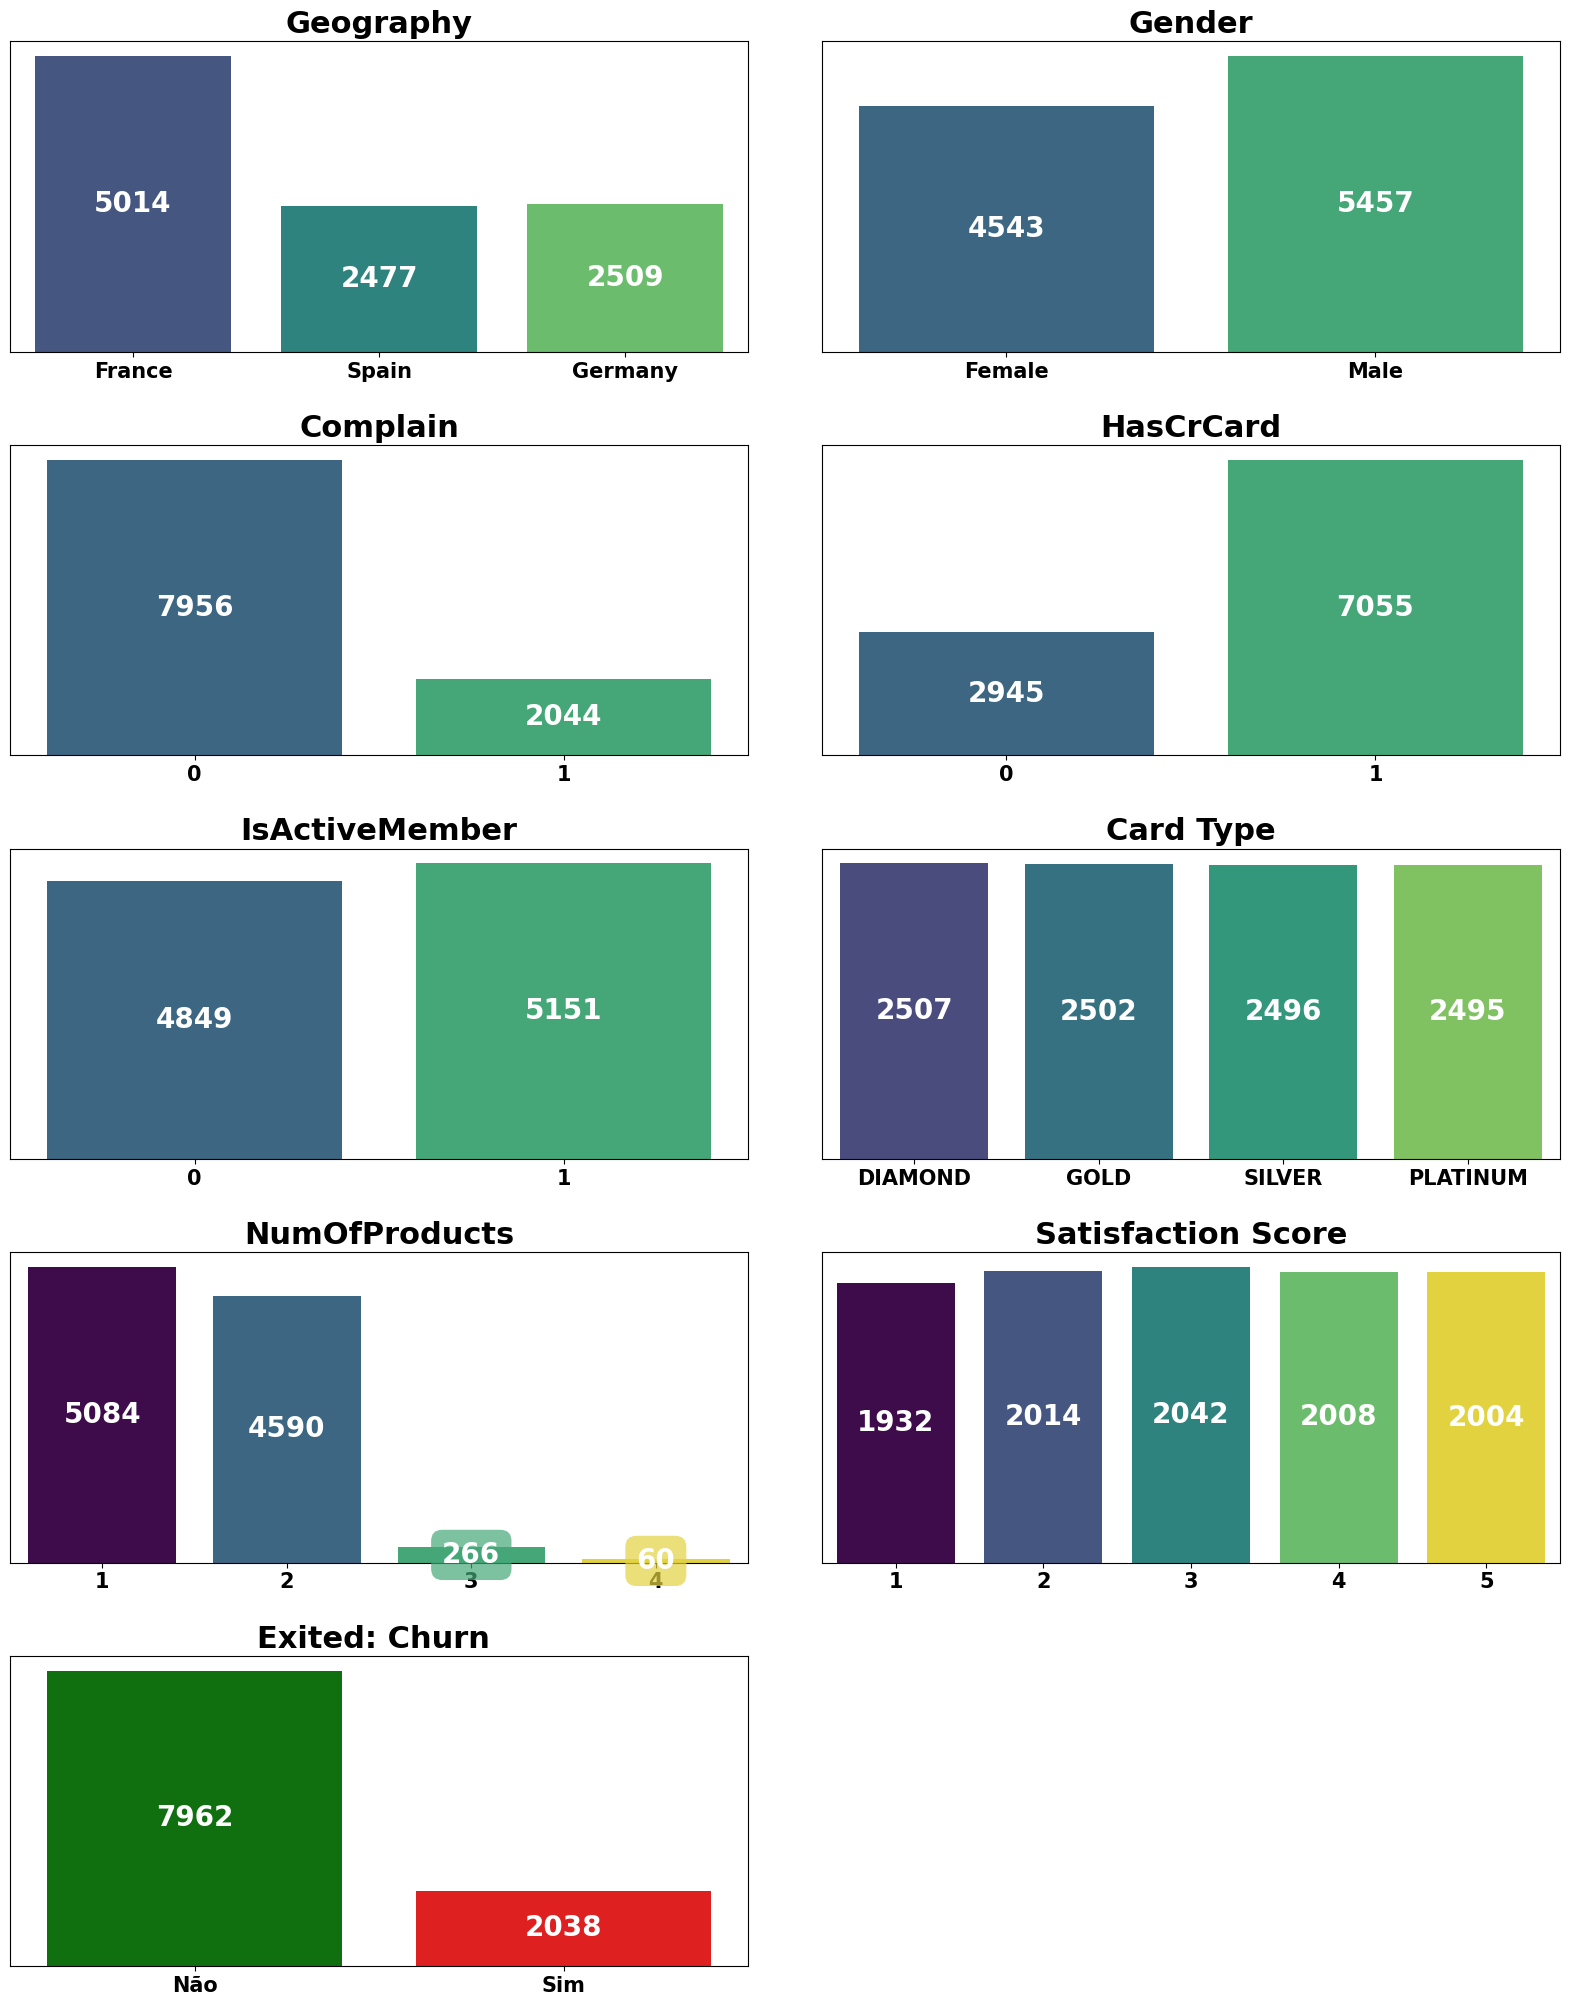

In [16]:
# Separando variáveis qualitativas (categóricas) para análise
quali = df[['HasCrCard', 'IsActiveMember', 'Geography', 'Gender',
            'Complain', 'Exited', 'Card Type', 'NumOfProducts', 'Satisfaction Score']]

# Convertendo as variáveis para o tipo 'object' (categóricas)
quali = quali.astype('object')

# Função para adicionar rótulos de valor (número de observações) nas barras dos gráficos
def add_value_labels(ax):
    for p in ax.patches:
        height = p.get_height()  # Altura da barra (número de observações)
        color = p.get_facecolor()  # Cor da barra
        ax.text(p.get_x() + p.get_width() / 2., height / 2.,  # Posição do texto
                f'{int(height)}',  # Valor a ser exibido
                ha='center', va='center', fontsize=20, color='white', fontweight='bold',  # Formatação do texto
                bbox=dict(facecolor=color, edgecolor='none', alpha=0.7,  # Caixa de fundo do texto
                          boxstyle='round,pad=0.4', linewidth=1))

# Configurando o tamanho da figura para os gráficos
plt.figure(figsize=(20, 25))

# Gráfico 1: Distribuição de Geography (País)
plt.subplot(5, 2, 1)  # Posição do gráfico na grade (5 linhas, 2 colunas, posição 1)
ax1 = plt.gca()  # Obtém o eixo atual
ax1.set_title('Geography', fontsize=22, fontweight='bold')  # Título do gráfico
sns.countplot(x='Geography', hue='Geography', palette='viridis', data=base_original, ax=ax1, legend=False)  # Gráfico de contagem
plt.xlabel('')  # Remove o rótulo do eixo X
plt.ylabel('')  # Remove o rótulo do eixo Y
plt.xticks(fontsize=15, rotation=0, fontweight='bold')  # Formatação dos rótulos do eixo X
plt.yticks([])  # Remove os rótulos do eixo Y
add_value_labels(ax1)  # Adiciona rótulos de valor nas barras

# Gráfico 2: Distribuição de Gender (Gênero)
plt.subplot(5, 2, 2)  # Posição do gráfico na grade (5 linhas, 2 colunas, posição 2)
ax2 = plt.gca()
ax2.set_title('Gender', fontsize=22, fontweight='bold')
sns.countplot(x='Gender', hue='Gender', palette='viridis', data=base_original, ax=ax2, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax2)

# Gráfico 3: Distribuição de Complain (Reclamações)
plt.subplot(5, 2, 3)
ax10 = plt.gca()
ax10.set_title('Complain', fontsize=22, fontweight='bold')
sns.countplot(x='Complain', hue='Complain', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# Gráfico 4: Distribuição de HasCrCard (Possui Cartão de Crédito)
plt.subplot(5, 2, 4)
ax5 = plt.gca()
ax5.set_title('HasCrCard', fontsize=22, fontweight='bold')
sns.countplot(x='HasCrCard', hue='HasCrCard', palette='viridis', data=base_original, ax=ax5, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax5)

# Gráfico 5: Distribuição de IsActiveMember (Membro Ativo)
plt.subplot(5, 2, 5)
ax6 = plt.gca()
ax6.set_title('IsActiveMember', fontsize=22, fontweight='bold')
sns.countplot(x='IsActiveMember', hue='IsActiveMember', palette='viridis', data=base_original, ax=ax6, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax6)

# Gráfico 6: Distribuição de Card Type (Tipo de Cartão)
plt.subplot(5, 2, 6)
ax10 = plt.gca()
ax10.set_title('Card Type', fontsize=22, fontweight='bold')
sns.countplot(x='Card Type', hue='Card Type', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# Gráfico 7: Distribuição de NumOfProducts (Número de Produtos)
plt.subplot(5, 2, 7)
ax10 = plt.gca()
ax10.set_title('NumOfProducts', fontsize=22, fontweight='bold')
sns.countplot(x='NumOfProducts', hue='NumOfProducts', palette='viridis', data=base_original, ax=ax10, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax10)

# Gráfico 8: Distribuição de Satisfaction Score (Pontuação de Satisfação)
plt.subplot(5, 2, 8)
ax11 = plt.gca()
ax11.set_title('Satisfaction Score', fontsize=22, fontweight='bold')
sns.countplot(x='Satisfaction Score', hue='Satisfaction Score', palette='viridis', data=base_original, ax=ax11, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

# Gráfico 9: Distribuição de Exited (Churn)
plt.subplot(5, 2, 9)
ax11 = plt.gca()
ax11.set_title('Exited: Churn ', fontsize=22, fontweight='bold')
custom_palette = ['green', 'red']  # Paleta de cores personalizada (verde para "Não", vermelho para "Sim")
sns.countplot(x='Exited', hue='Exited', palette=custom_palette, data=base_original, ax=ax11, legend=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15, rotation=0, fontweight='bold')
plt.yticks([])
add_value_labels(ax11)

# Ajustando os rótulos do eixo X para "Não" e "Sim"
ax11.set_xticks([0, 1])
ax11.set_xticklabels(['Não', 'Sim'], fontsize=15, fontweight='bold')

# Ajustando o espaçamento entre os gráficos
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Exibindo os gráficos
plt.show()

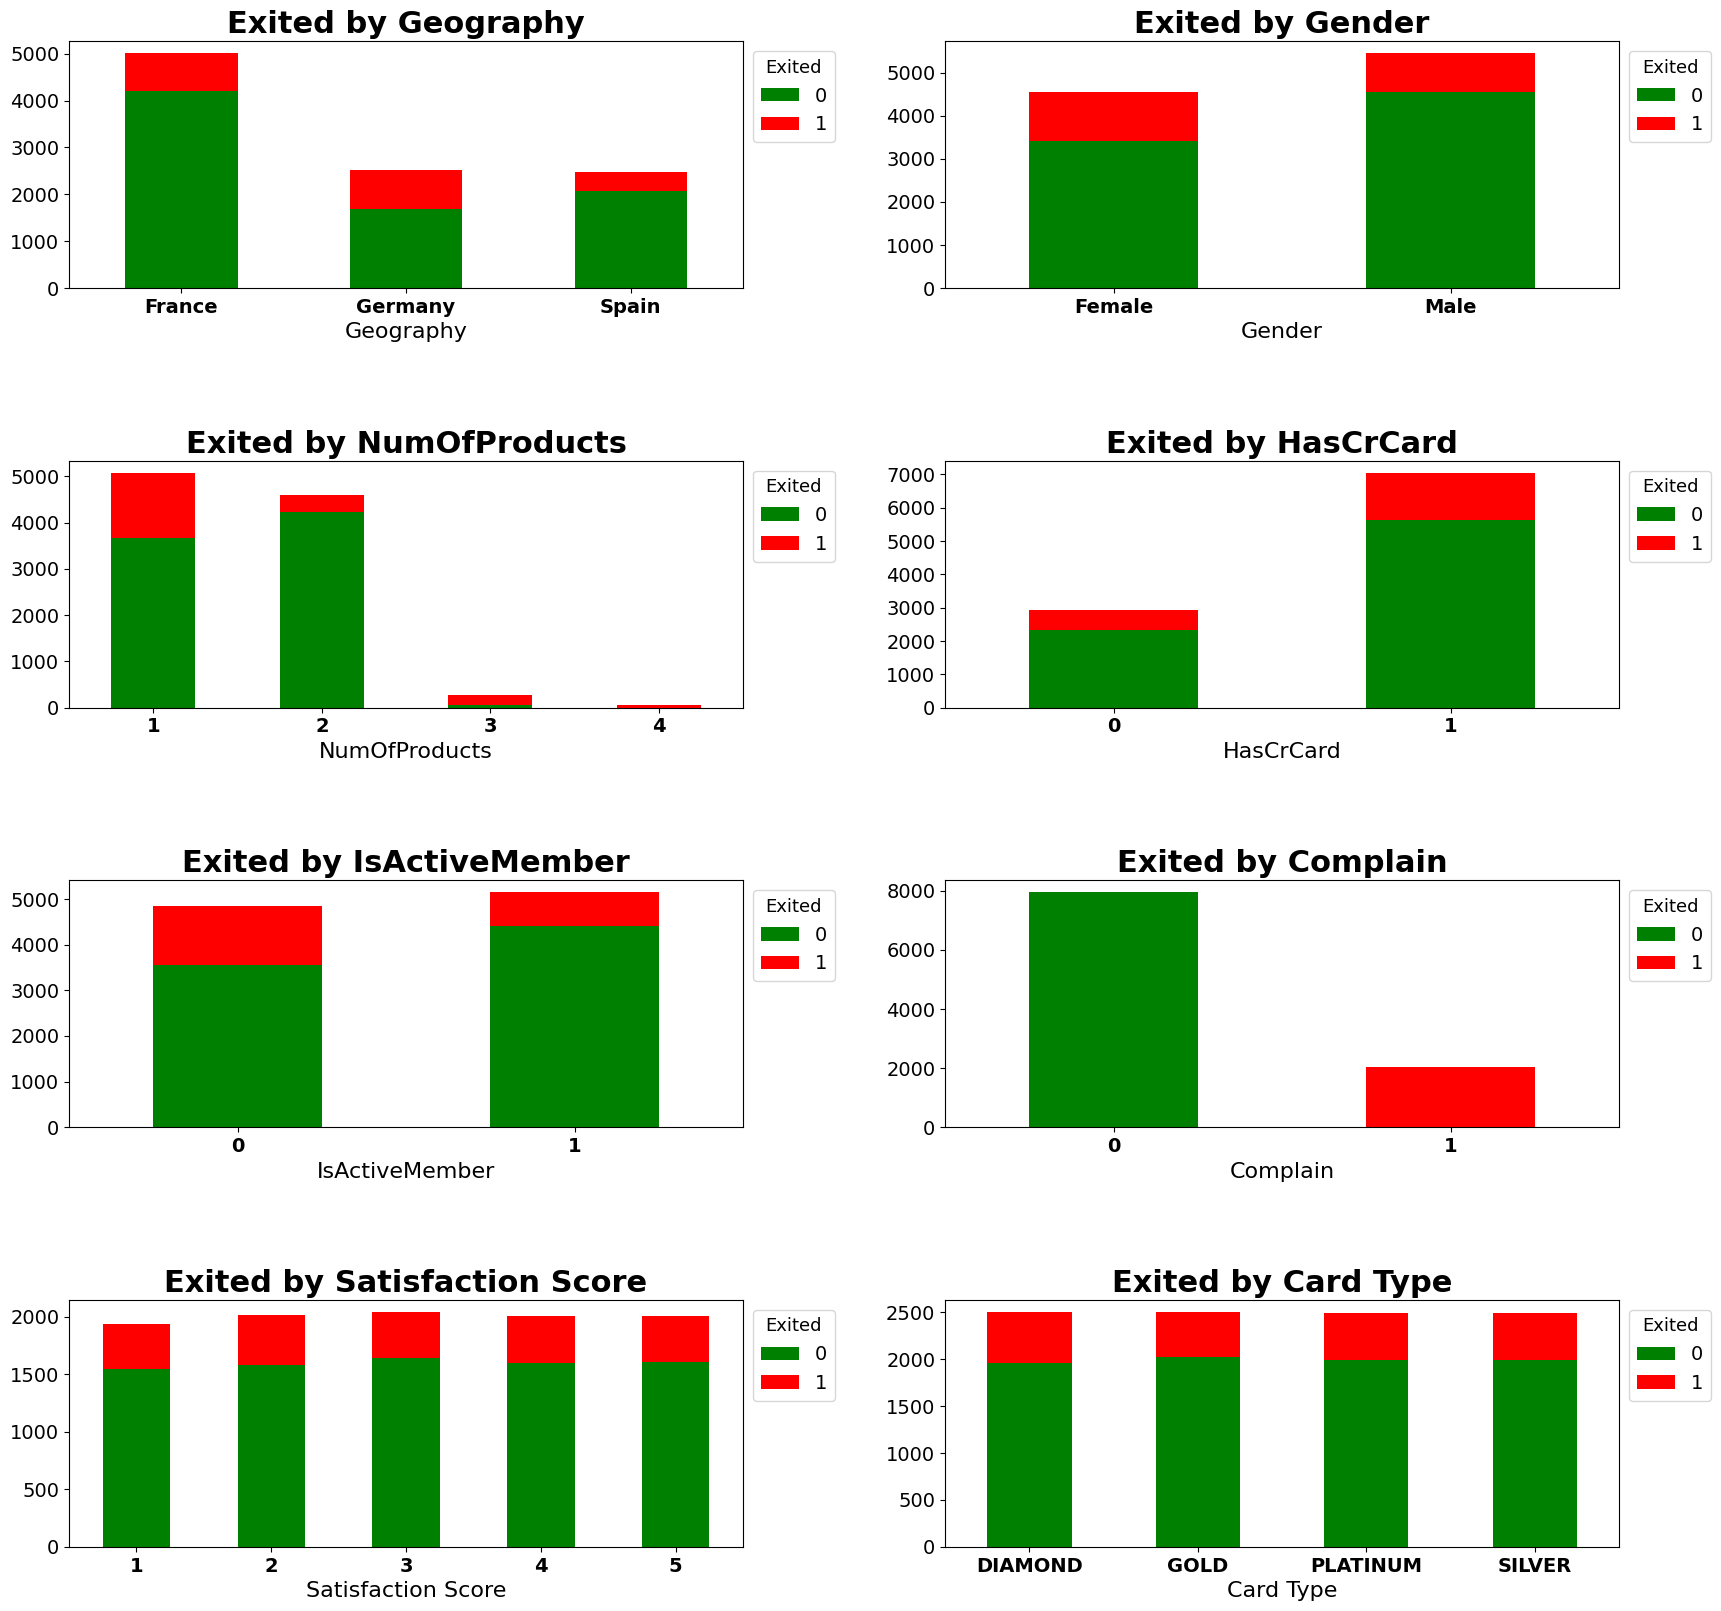

In [19]:
import matplotlib.pyplot as plt

# Define o tamanho da figura para exibição dos gráficos
plt.figure(figsize=(20, 25))

# Função para adicionar legenda aos gráficos
# Coloca a legenda no canto superior esquerdo e garante os rótulos 'Exited' e 'Not Exited'
def add_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    if not handles:
        # Se não houver handles, força a adição manual das cores verde e vermelha
        handles = [plt.Rectangle((0,0),1,1, color=c) for c in ['green', 'red']]
        labels = ['Not Exited', 'Exited']

    # Adiciona a legenda na posição superior esquerda fora da área do gráfico
    ax.legend(handles, labels, loc='upper left', fontsize=14, title='Exited', title_fontsize='13',
              bbox_to_anchor=(1.0, 1))

# Criação dos gráficos para cada variável categórica, comparando com a variável alvo 'Exited'

# Geography (País de residência)
plt.subplot(5, 2, 1)
counts = dados_clientes.groupby(['Geography', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by Geography', fontsize=22, fontweight='bold')
plt.xlabel('Geography', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Gender (Gênero do cliente)
plt.subplot(5, 2, 2)
counts = dados_clientes.groupby(['Gender', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by Gender', fontsize=22, fontweight='bold')
plt.xlabel('Gender', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# NumOfProducts (Número de produtos adquiridos pelo cliente)
plt.subplot(5, 2, 3)
counts = dados_clientes.groupby(['NumOfProducts', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by NumOfProducts', fontsize=22, fontweight='bold')
plt.xlabel('NumOfProducts', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# HasCrCard (Cliente possui cartão de crédito?)
plt.subplot(5, 2, 4)
counts = dados_clientes.groupby(['HasCrCard', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by HasCrCard', fontsize=22, fontweight='bold')
plt.xlabel('HasCrCard', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# IsActiveMember (Cliente é um membro ativo?)
plt.subplot(5, 2, 5)
counts = dados_clientes.groupby(['IsActiveMember', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by IsActiveMember', fontsize=22, fontweight='bold')
plt.xlabel('IsActiveMember', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Complain (Cliente já fez reclamação?)
plt.subplot(5, 2, 6)
counts = dados_clientes.groupby(['Complain', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by Complain', fontsize=22, fontweight='bold')
plt.xlabel('Complain', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Satisfaction Score (Nível de satisfação do cliente)
plt.subplot(5, 2, 7)
counts = dados_clientes.groupby(['Satisfaction Score', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by Satisfaction Score', fontsize=22, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Card Type (Tipo de cartão do cliente)
plt.subplot(5, 2, 8)
counts = dados_clientes.groupby(['Card Type', 'Exited']).size().unstack().fillna(0)
ax = counts.plot(kind='bar', stacked=True, color=['green', 'red'], ax=plt.gca())
plt.title('Exited by Card Type', fontsize=22, fontweight='bold')
plt.xlabel('Card Type', fontsize=16)
plt.xticks(fontsize=14, rotation=0, fontweight='bold')
plt.yticks(fontsize=14)
add_legend(ax)

# Ajusta o espaçamento entre os subgráficos para melhor visualização
plt.subplots_adjust(hspace=0.7, wspace=0.3)


In [20]:
import warnings
import pandas as pd

# Suprime todos os warnings de futuro para manter o código mais limpo
warnings.filterwarnings('ignore', category=FutureWarning)

# Lista de variáveis categóricas que serão convertidas em variáveis dummy
cols_to_transform = ['HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'Card Type']

# Convertendo as colunas categóricas para o tipo string (boa prática antes de aplicar one-hot encoding)
df.loc[:, cols_to_transform] = df.loc[:, cols_to_transform].astype(str)

# Aplicando one-hot encoding para transformar variáveis categóricas em variáveis binárias
# O parâmetro 'drop_first=False' mantém todas as categorias (sem excluir a primeira)
df_dummies = pd.get_dummies(df, columns=cols_to_transform, dtype=int, drop_first=False)

# Convertendo a variável alvo 'Exited' para o tipo numérico, pois o modelo requer variáveis numéricas
df_dummies['Exited'] = df_dummies['Exited'].astype('int64')

# Exibe os tipos de dados do dataframe resultante
print(df_dummies.dtypes)


CreditScore             int64
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
EstimatedSalary       float64
Complain                int64
Satisfaction Score      int64
Point Earned            int64
Exited                  int64
HasCrCard_0             int64
HasCrCard_1             int64
IsActiveMember_0        int64
IsActiveMember_1        int64
Geography_France        int64
Geography_Germany       int64
Geography_Spain         int64
Gender_Female           int64
Gender_Male             int64
Card Type_DIAMOND       int64
Card Type_GOLD          int64
Card Type_PLATINUM      int64
Card Type_SILVER        int64
dtype: object


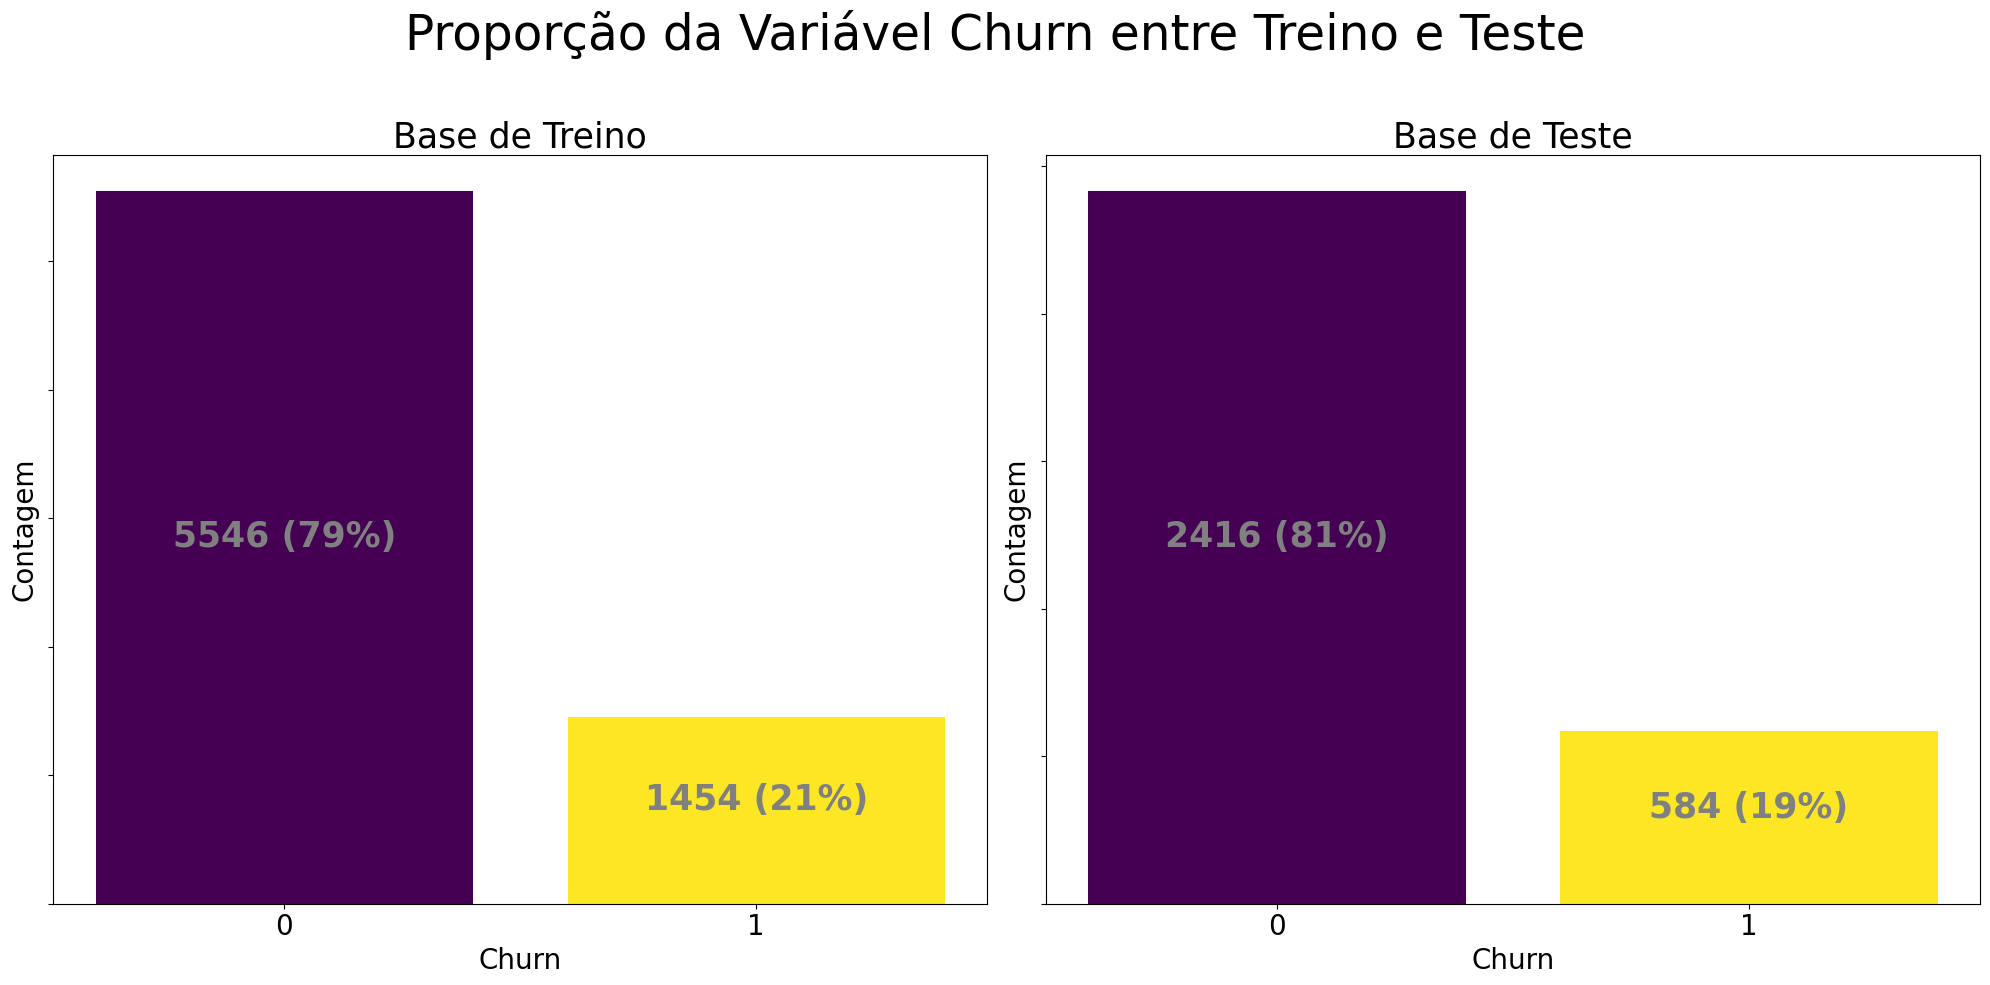

In [21]:
# X ---> Variáveis explicativas (features do modelo)
# Y ---> Variável alvo (target, evento de estudo, "churn" neste caso)

# Removendo a coluna 'Complain', pois não será utilizada no modelo
df_dummies = df_dummies.drop(columns=['Complain'])

# Definindo X (variáveis explicativas) e Y (variável alvo)
X = df_dummies.drop('Exited', axis=1)  # Exclui a variável alvo para que X contenha apenas as features
y = df_dummies['Exited']  # Define a variável alvo (churn)

# Criando novas variáveis quadráticas para capturar relações não lineares com a variável alvo
X['Balance_Squared'] = X['Balance'] ** 2  # Quadrado do saldo bancário
X['Age_Squared'] = X['Age'] ** 2  # Quadrado da idade do cliente
X['CreditScore_Squared'] = X['CreditScore'] ** 2  # Quadrado da pontuação de crédito
X['NumOfProducts_Squared'] = X['NumOfProducts'] ** 2  # Quadrado do número de produtos adquiridos
X['Tenure_Squared'] = X['Tenure'] ** 2  # Quadrado do tempo de relacionamento com o banco
X['EstimatedSalary_Squared'] = X['EstimatedSalary'] ** 2  # Quadrado do salário estimado

# Separando os dados em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualizando a distribuição da variável alvo (churn) nos conjuntos de treino e teste
churn_counts_train = y_train.value_counts()  # Contagem de churn na base de treino
churn_counts_test = y_test.value_counts()  # Contagem de churn na base de teste

# Criando a figura para os gráficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Cria dois gráficos lado a lado
fig.suptitle('Proporção da Variável Churn entre Treino e Teste', fontsize=35)  # Título geral
cmap = plt.get_cmap('viridis', 2)  # Define a paleta de cores

# Gráfico da base de treino
bars_train = axs[0].bar(churn_counts_train.index, churn_counts_train.values, color=cmap(range(2)))
axs[0].set_title('Base de Treino', fontsize=25)  # Título do gráfico
axs[0].set_xlabel('Churn', fontsize=20)  # Nome do eixo X
axs[0].set_ylabel('Contagem', fontsize=20)  # Nome do eixo Y
axs[0].set_xticks([0, 1])  # Define os rótulos do eixo X (0 = não churn, 1 = churn)
axs[0].set_xticklabels(['0', '1'], fontsize=20)  # Define os rótulos como strings
axs[0].set_yticklabels([])  # Oculta os valores do eixo Y para manter o gráfico limpo

# Adicionando rótulos de dados no gráfico de treino
total_train = churn_counts_train.sum()  # Total de amostras na base de treino
for bar in bars_train:
    count = int(bar.get_height())  # Obtém a altura da barra (número de amostras)
    percentage = round(count / total_train * 100)  # Calcula a porcentagem
    label = f'{count} ({percentage}%)'  # Formata o rótulo com número absoluto e percentual
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                label, ha='center', color='gray', fontsize=25, weight='bold')  # Adiciona texto dentro das barras

# Gráfico da base de teste
bars_test = axs[1].bar(churn_counts_test.index, churn_counts_test.values, color=cmap(range(2)))
axs[1].set_title('Base de Teste', fontsize=25)  # Título do gráfico
axs[1].set_xlabel('Churn', fontsize=20)  # Nome do eixo X
axs[1].set_ylabel('Contagem', fontsize=20)  # Nome do eixo Y
axs[1].set_xticks([0, 1])  # Define os rótulos do eixo X (0 = não churn, 1 = churn)
axs[1].set_xticklabels(['0', '1'], fontsize=20)  # Define os rótulos como strings
axs[1].set_yticklabels([])  # Oculta os valores do eixo Y

# Adicionando rótulos de dados no gráfico de teste
total_test = churn_counts_test.sum()  # Total de amostras na base de teste
for bar in bars_test:
    count = int(bar.get_height())  # Obtém a altura da barra (número de amostras)
    percentage = round(count / total_test * 100)  # Calcula a porcentagem
    label = f'{count} ({percentage}%)'  # Formata o rótulo com número absoluto e percentual
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2,
                label, ha='center', color='gray', fontsize=25, weight='bold')  # Adiciona texto dentro das barras

# Ajusta o layout para evitar sobreposição e garantir espaço para o título
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()  # Exibe os gráficos


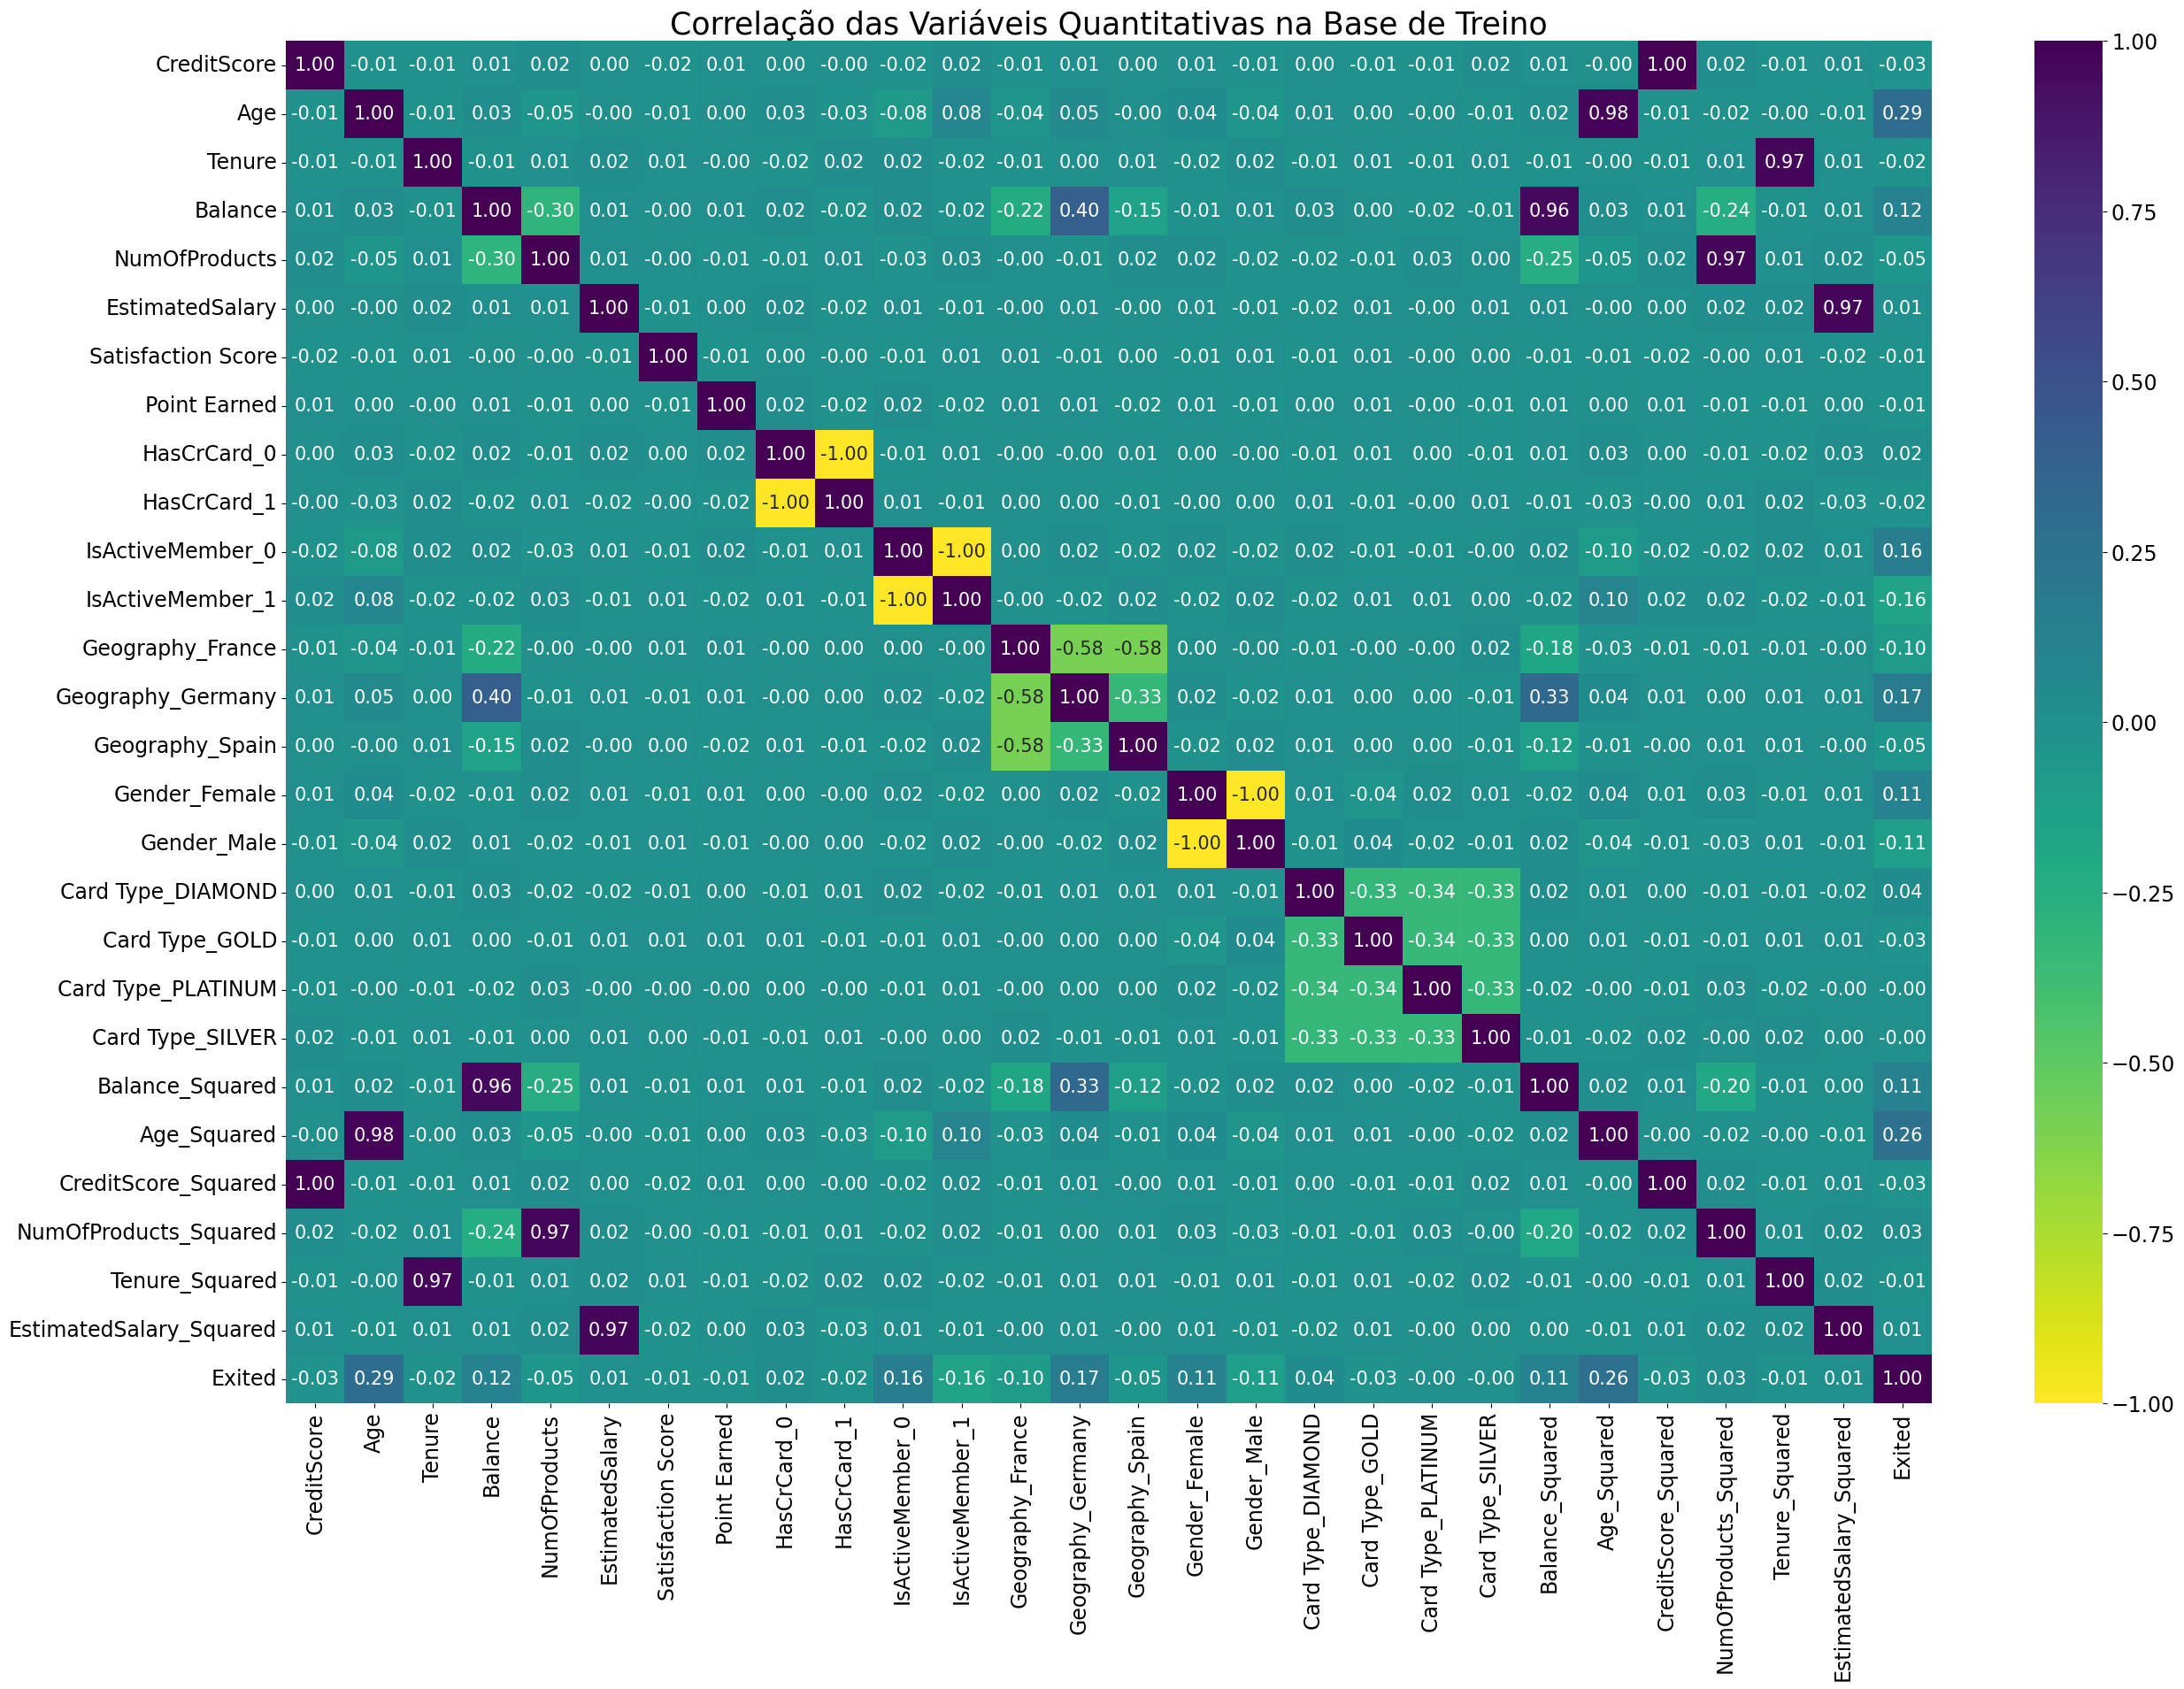

In [22]:
# Observando Multicolinearidade na base de treino

# Junta a base de treino (X_train) e o target (y_train) em um único dataframe para análise de correlação
teste_multco_treino = pd.concat([X_train, y_train], axis=1)

# Calcula a matriz de correlação entre todas as variáveis da base de treino, arredondando para 2 casas decimais
correlation_matrix_treino = teste_multco_treino.corr().round(2)
correlation_matrix_treino  # Exibe a matriz de correlação

# Criação de um mapa de calor para visualizar a correlação entre as variáveis quantitativas

plt.figure(figsize=(30, 20))  # Define o tamanho da figura para melhor visualização

# Gera o heatmap da matriz de correlação
heatmap = sns.heatmap(
    correlation_matrix_treino,  # Matriz de correlação calculada anteriormente
    annot=True,  # Exibe os valores numéricos dentro do mapa de calor
    fmt=".2f",  # Define o formato dos valores numéricos para 2 casas decimais
    cmap=plt.cm.viridis_r,  # Utiliza a paleta de cores 'viridis' (ou invertida com '_r')
    # A paleta 'viridis' é recomendada para facilitar a visualização por pessoas daltônicas
    annot_kws={'size': 15},  # Define o tamanho da fonte dos números dentro do heatmap
    vmin=-1, vmax=1  # Define os valores mínimo e máximo da escala de correlação (-1 a 1)
)

# Ajusta os rótulos dos eixos para melhor legibilidade
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)

# Adiciona um título ao gráfico
plt.title('Correlação das Variáveis Quantitativas na Base de Treino', fontsize=25)

# Ajusta o tamanho dos rótulos da barra de cores (colorbar)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)

# Exibe o gráfico
plt.show()


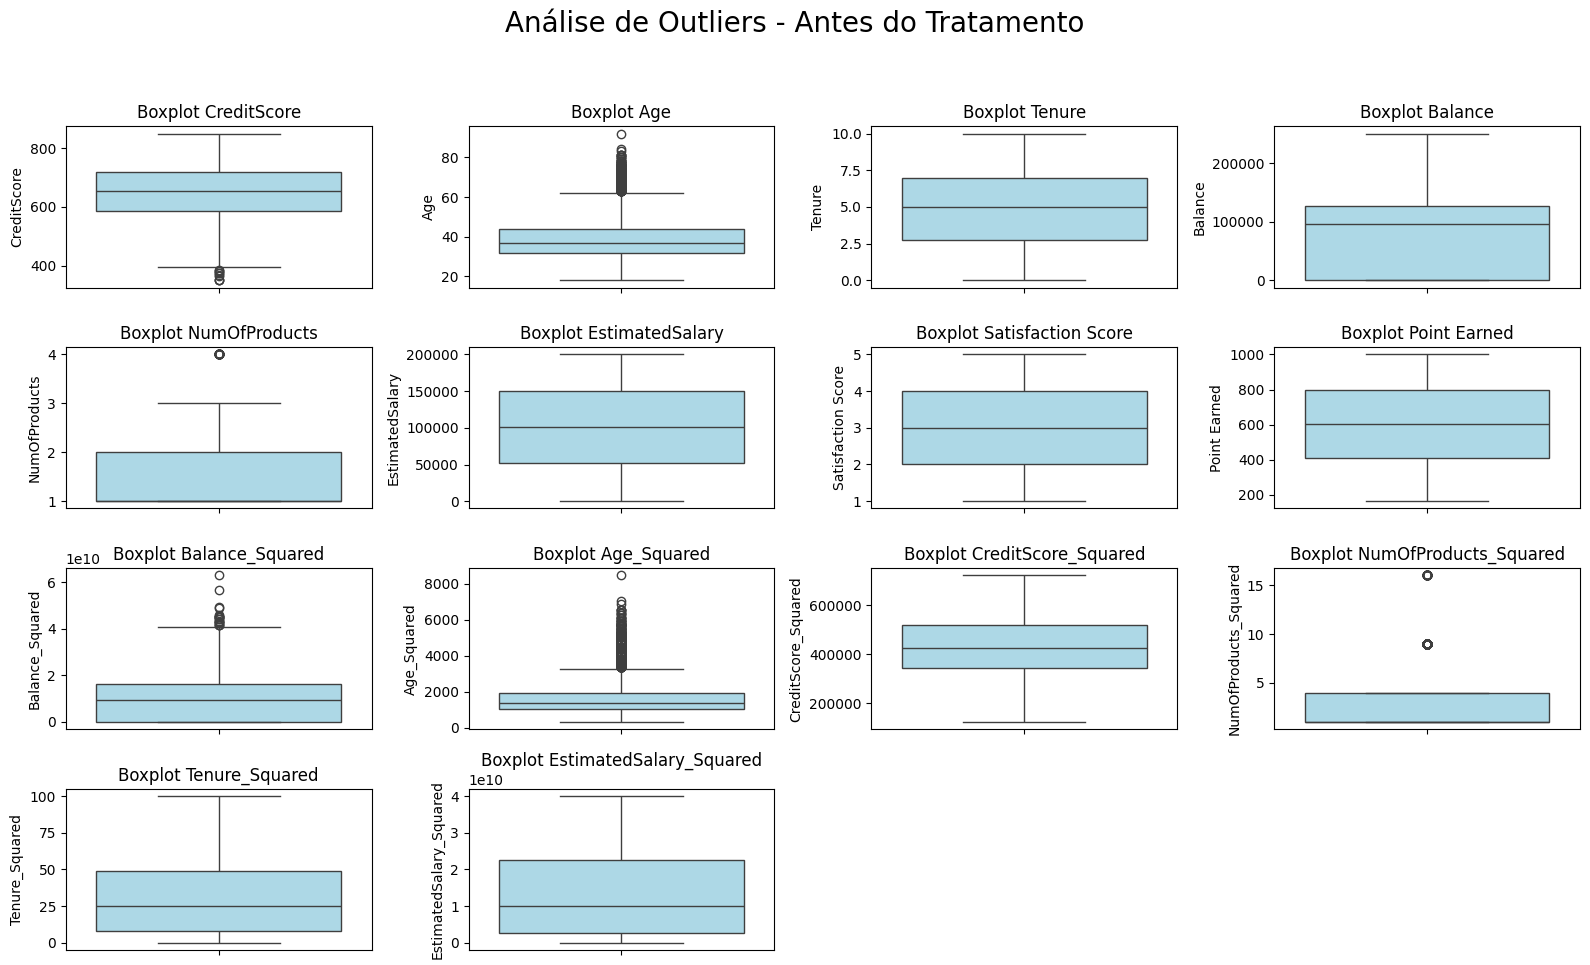

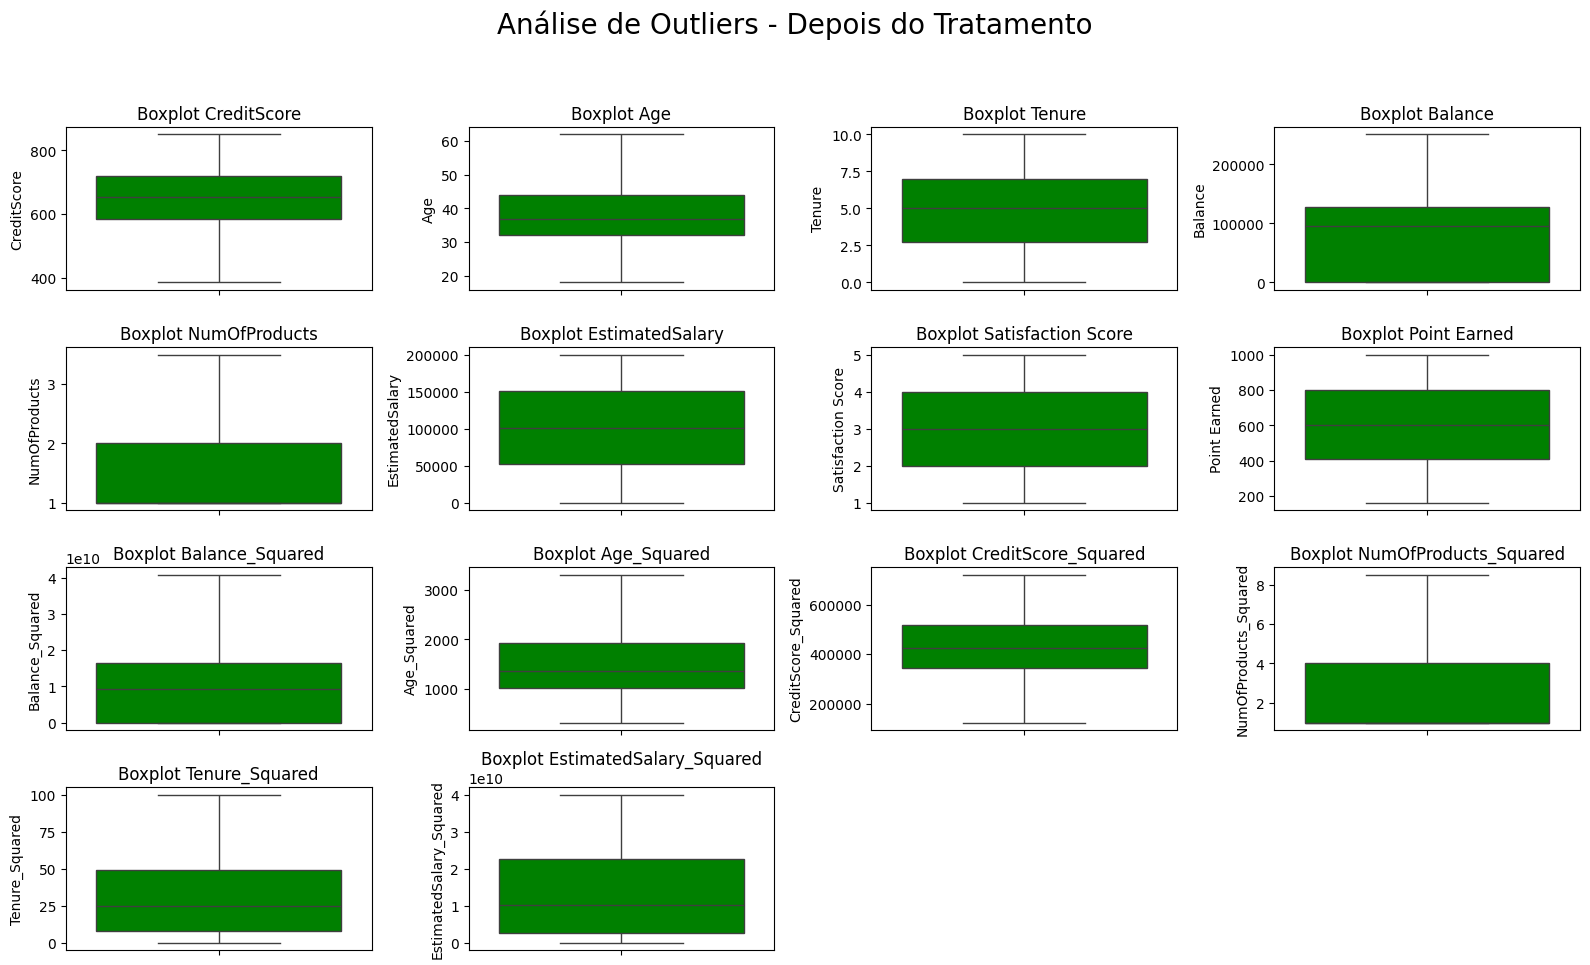

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variáveis para análise e tratamento
target_vars = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary',
    'Satisfaction Score', 'Point Earned',
    # Variáveis quadráticas
    'Balance_Squared', 'Age_Squared', 'CreditScore_Squared', 'NumOfProducts_Squared',
    'Tenure_Squared', 'EstimatedSalary_Squared'
]

# Função para tratamento de outliers (Winsorization)
def tratar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
    df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])

# Criar subplots antes do tratamento
plt.figure(figsize=(16, 12))
for i, var in enumerate(target_vars):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=teste_multco_treino[var], boxprops=dict(facecolor='lightblue'))
    plt.title(f'Boxplot {var}', fontsize=12)
plt.suptitle('Análise de Outliers - Antes do Tratamento', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Aplicação do tratamento
for var in target_vars:
    tratar_outliers(teste_multco_treino, var)

# Criar subplots depois do tratamento
plt.figure(figsize=(16, 12))
for i, var in enumerate(target_vars):
    plt.subplot(5, 4, i + 1)
    sns.boxplot(y=teste_multco_treino[var], boxprops=dict(facecolor='green'))
    plt.title(f'Boxplot {var}', fontsize=12)
plt.suptitle('Análise de Outliers - Depois do Tratamento', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [24]:
#BASE DE TREINO
teste_multco_treino

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
9069,619.0,32.0,4.0,175406.13,2.0,172792.43,1.0,707.0,0,1,0,1,0,0,1,1,0,1,0,0,0,3.076731e+10,1024.0,383161.0,4.0,16.0,2.985722e+10,1
2603,643.0,34.0,7.0,160426.07,1.0,188533.11,3.0,806.0,1,0,0,1,0,1,0,1,0,0,1,0,0,2.573652e+10,1156.0,413449.0,1.0,49.0,3.554473e+10,0
7738,561.0,33.0,6.0,0.00,2.0,173680.39,3.0,220.0,1,0,1,0,1,0,0,0,1,1,0,0,0,0.000000e+00,1089.0,314721.0,4.0,36.0,3.016488e+10,0
1579,618.0,41.0,8.0,37702.79,1.0,195775.48,5.0,615.0,0,1,0,1,0,1,0,0,1,0,1,0,0,1.421500e+09,1681.0,381924.0,1.0,64.0,3.832804e+10,0
5058,714.0,37.0,9.0,148466.93,2.0,151280.96,3.0,936.0,1,0,0,1,1,0,0,0,1,0,0,0,1,2.204243e+10,1369.0,509796.0,4.0,81.0,2.288593e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768.0,54.0,8.0,69712.74,1.0,69381.05,3.0,569.0,0,1,0,1,1,0,0,0,1,0,0,0,1,4.859866e+09,2916.0,589824.0,1.0,64.0,4.813730e+09,0
5191,682.0,58.0,1.0,0.00,1.0,706.50,4.0,709.0,0,1,0,1,1,0,0,1,0,0,0,1,0,0.000000e+00,3304.0,465124.0,1.0,1.0,4.991422e+05,0
5390,735.0,38.0,1.0,0.00,3.0,92220.12,5.0,678.0,1,0,1,0,1,0,0,1,0,0,0,0,1,0.000000e+00,1444.0,540225.0,8.5,1.0,8.504551e+09,1
860,667.0,43.0,8.0,190227.46,1.0,97508.04,3.0,680.0,0,1,1,0,1,0,0,0,1,1,0,0,0,3.618649e+10,1849.0,444889.0,1.0,64.0,9.507818e+09,1


In [25]:
# BASE DE TESTE
base_corrige_teste = pd.concat([X_test,y_test], axis = 1)
base_corrige_teste


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Balance_Squared,Age_Squared,CreditScore_Squared,NumOfProducts_Squared,Tenure_Squared,EstimatedSalary_Squared,Exited
6252,596,32,3,96709.07,2,41788.37,1,709,1,0,1,0,0,1,0,0,1,0,1,0,0,9.352644e+09,1024,355216,4,9,1.746268e+09,0
4684,623,43,1,0.00,2,146379.30,2,508,0,1,0,1,1,0,0,0,1,0,0,0,1,0.000000e+00,1849,388129,4,1,2.142690e+10,0
1731,601,44,4,0.00,2,58561.31,1,281,0,1,1,0,0,0,1,1,0,0,1,0,0,0.000000e+00,1936,361201,4,16,3.429427e+09,0
4742,506,59,8,119152.10,2,170679.74,2,979,0,1,0,1,0,1,0,0,1,0,0,0,1,1.419722e+10,3481,256036,4,64,2.913157e+10,0
4521,560,27,7,124995.98,1,114669.79,5,457,0,1,0,1,0,0,1,1,0,0,0,0,1,1.562400e+10,729,313600,1,49,1.314916e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,731,39,2,126816.18,1,74850.93,1,403,0,1,0,1,0,0,1,1,0,0,0,0,1,1.608234e+10,1521,534361,1,4,5.602662e+09,0
1074,535,31,7,111855.04,2,36278.89,1,467,0,1,0,1,1,0,0,1,0,1,0,0,0,1.251155e+10,961,286225,4,49,1.316158e+09,0
3063,609,32,7,71872.19,1,151924.90,2,484,0,1,0,1,1,0,0,0,1,0,0,0,1,5.165612e+09,1024,370881,1,49,2.308118e+10,0
6487,580,31,2,0.00,2,64014.24,1,316,1,0,0,1,1,0,0,0,1,0,0,1,0,0.000000e+00,961,336400,4,4,4.097823e+09,0


## Modelagem: Aplicando MLP Classifier com Scikit-learn
A MLP (Multilayer Perceptron) é uma rede neural artificial composta por múltiplas camadas de neurônios, amplamente utilizada em tarefas de classificação e regressão. A seguir, descrevemos as principais etapas para sua aplicação com o Scikit-learn:

1️⃣ Pré-processamento e preparação dos dados


Definição das variáveis explicativas (X_train) e da variável alvo (y_train).

2️⃣ Seleção de features com Random Forest

Um modelo Random Forest é treinado para identificar as variáveis mais relevantes.
Apenas as variáveis com importância maior que 0.01 foram selecionadas para o modelo.

3️⃣ Escalonamento dos dados

Utilização do StandardScaler para normalizar as variáveis selecionadas (X_train e X_test), garantindo que todas tenham a mesma escala.

------------------------
MLP - Classifier
------------------------
------------------------
Início: 2025-03-06 23:01:35.260762
------------------------
Índices de X_test e y_test já estavam alinhados.


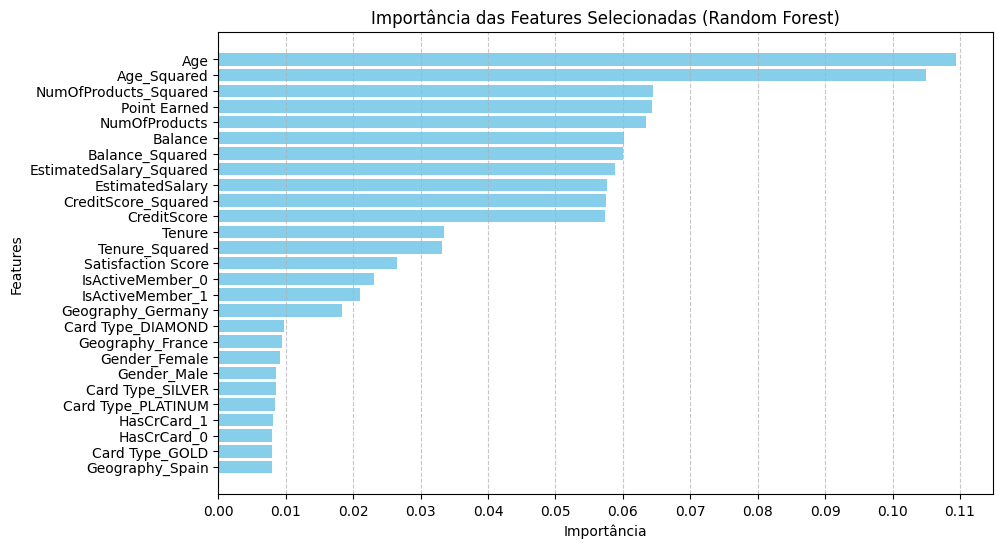

Processando tensores: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 1575.62it/s]

X_train_mlp shape: (7000, 17)
y_train_mlp shape: (7000,)
X_test_mlp shape: (3000, 17)
y_test_mlp shape: (3000,)


In [26]:
print('------------------------')
print("MLP - Classifier")
print('------------------------')

# Desativando os warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
warnings.filterwarnings("ignore", category=UserWarning, module='optuna')
warnings.filterwarnings("ignore", category=FutureWarning, module='optuna')
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.getLogger("optuna").setLevel(logging.CRITICAL)



# início
start_time_utc = datetime.utcnow() - timedelta(hours=3)
print('------------------------')
print("Início:", start_time_utc)
print('------------------------')


######################################## PRE-PROCESSAMENTO E PREPARACAO NOS DADOS ###################################################################


# Defini variáveis de treinamento
X_train = teste_multco_treino.drop('Exited', axis=1)
y_train = teste_multco_treino['Exited']

# Verifica e conserta desalinhamento de índices caso tenha (X_test e y_test)
if not X_test.index.equals(y_test.index):
    print("Índices de X_test e y_test não estavam alinhados. Realinhando y_test.")
    y_test = y_test.loc[X_test.index]
else:
    print("Índices de X_test e y_test já estavam alinhados.")

# Concatena os dados corrigidos para criar a base de teste
base_corrige_teste = pd.concat([X_test, y_test], axis=1)

# Redefini X_test e y_test com índices corrigidos e verificados
X_test = base_corrige_teste.drop('Exited', axis=1)
y_test = base_corrige_teste['Exited']




# Criar e treinar o modelo Random Forest para selecionar as melhores variaveis

# Mais estavel que o mutual_info_classif e melhor que ANOVA
# (ele captura bem relacoes nao lineares e nao sofre variacoes como mutual_info)

#detalhe importante, nao tem predict(), somente o fit()


rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importances = rf.feature_importances_

# Criar DataFrame com os nomes das features e suas importâncias
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Filtrar features com importância maior que 0.01 (ou outro threshold desejado)
selected_features = feature_df[feature_df['Importance'] > 0.01]['Feature'].tolist()

# Ordenar as features pela importância (do menor para o maior)
feature_df = feature_df.sort_values(by='Importance', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features Selecionadas (Random Forest)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(feature_df['Importance'])+0.01, 0.01))
# Mostrar o gráfico
plt.show()



# Aplicar a seleção das mesmas features ao conjunto de treino e teste
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

bar = tqdm(total=1, desc="Processando tensores", ncols=100, position=0) #barra de progresso

# arrays para o modelo
X_train_mlp = X_train_selected
y_train_mlp = y_train.values
X_test_mlp = X_test_selected
y_test_mlp = y_test.values

bar.update(1) #incrementa barra
bar.close()#fecha barra

# Verificando os shapes depois de criados
# para ter certeza da compatibilidade de tamanhos
print(f"X_train_mlp shape: {X_train_mlp.shape}")
print(f"y_train_mlp shape: {y_train_mlp.shape}")
print(f"X_test_mlp shape: {X_test_mlp.shape}")
print(f"y_test_mlp shape: {y_test_mlp.shape}")